STAKEHOLDER: Leading Telecommunications Company

PROBLEM: The stakeholder has approached up to find out how they can reduce churn.

BUSINESS UNDERSTADING: Build a classifier to predict whether a customer will ("soon") stop doing business with our stakeholder. Optimize to reduce amount of money lost due to churn. This is a binary classification problem.

PRIMARY METRIC: Recall 

## EDA

Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, make_scorer, recall_score, plot_roc_curve, classification_report, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from statsmodels.api import qqplot
from scipy import stats

Load and explore dataset

In [5]:
df = pd.read_csv('data/cell2celltrain.csv')
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [32]:
pd.set_option('display.max_columns', None)
df.describe()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,ZipCode
count,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000
mean,0.286320,58.717374,525.021466,46.834961,0.891841,39.754040,1.226327,-11.656175,-1.175937,6.010556,4.077814,28.290957,1.874031,0.298422,114.709214,25.350316,8.163666,90.450414,67.711378,10.149178,0.011772,1.837229,18.730805,1.529004,1.350860,1.805093,1.558711,380.020843,31.338258,21.147592,0.246603,0.138688,0.902577,0.190384,0.083072,0.368226,0.383603,0.014994,0.057405,0.188616,0.688234,0.035496,0.018331,0.193178,0.051475,4.402677,0.013547,0.053686,0.032582,2.864528,581.710363
std,0.452045,44.317244,528.510155,23.759492,2.224725,96.091606,9.848360,255.858193,39.392124,9.036653,10.836468,38.860429,5.111285,1.171084,166.107185,35.024146,16.586856,104.600936,92.736063,15.456031,0.582402,5.590515,9.739418,1.225841,0.667839,1.330834,0.906256,252.290072,22.091593,23.926589,0.431038,0.345624,0.296536,0.392608,0.275994,0.482328,0.486268,0.121531,0.232617,0.391207,0.463220,0.201964,0.142854,0.394796,0.266490,3.110498,0.115602,0.382677,0.177541,1.568627,245.600548
min,0.000000,-6.170000,0.000000,-6.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,201.000000
25%,0.000000,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.000000,0.700000,0.000000,5.300000,0.000000,0.000000,8.500000,3.300000,0.000000,23.300000,11.000000,2.000000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,323.000000
50%,0.000000,48.380000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,1.000000,16.300000,0.000000,0.000000,52.900000,13.700000,2.000000,62.000000,35.700000,5.300000,0.000000,0.300000,16.000000,1.000000,1.000000,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,2.000000,610.000000
75%,1.000000,70.910000,722.000000,60.000000,0.990000,40.000000,0.300000,65.000000,1.600000,7.700000,3.700000,36.300000,1.700000,0.300000,1

## Cleaning

Dropped null values and eliminated unuseful columns

In [8]:
df.dropna(how='any', inplace=True)
df.drop(['CustomerID', 'Homeownership', 'NotNewCellphoneUser', 'HandsetPrice',
'PrizmCode', 'Occupation', 'MaritalStatus'], axis=1, inplace=True)

Replaced service area data with zip code

In [9]:
df['ZipCode'] = df['ServiceArea'].str[-3:].astype(int) 
df = df.drop('ServiceArea', axis=1)

Converted categorical strings to numeric data

In [10]:
df.replace(to_replace='Yes', value=1, inplace=True) 
df.replace(to_replace='No', value=0, inplace=True) 
df['CreditRating'] = (df['CreditRating'].str[0]).astype(int)

In [11]:
df

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,ZipCode
0,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,1,0,0,0,4,0,0,1,1,503
1,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0,0,1,0,5,0,0,0,4,412
2,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0,0,1,0,6,0,0,0,3,414
3,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0,0,1,0,6,0,0,0,4,412
4,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0,0,0,0,9,0,1,0,1,918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,0,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,...,0,0,0,0,4,0,0,0,2,619
51037,0,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,...,0,0,0,0,3,0,0,0,3,760
51040,0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,...,0,0,0,0,7,0,0,0,1,818
51041,1,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,4.0,...,0,0,0,0,2,0,0,0,5,562


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49752 entries, 0 to 51043
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49752 non-null  int64  
 1   MonthlyRevenue             49752 non-null  float64
 2   MonthlyMinutes             49752 non-null  float64
 3   TotalRecurringCharge       49752 non-null  float64
 4   DirectorAssistedCalls      49752 non-null  float64
 5   OverageMinutes             49752 non-null  float64
 6   RoamingCalls               49752 non-null  float64
 7   PercChangeMinutes          49752 non-null  float64
 8   PercChangeRevenues         49752 non-null  float64
 9   DroppedCalls               49752 non-null  float64
 10  BlockedCalls               49752 non-null  float64
 11  UnansweredCalls            49752 non-null  float64
 12  CustomerCareCalls          49752 non-null  float64
 13  ThreewayCalls              49752 non-null  flo

In [13]:
df.Churn.value_counts()

0    35507
1    14245
Name: Churn, dtype: int64

## Model Analysis

Assign x and y values, train_test_split, and scale + SMOTE data

In [14]:
x = df.drop('Churn', axis=1)
y = df.Churn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15) 

scale = StandardScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

sm = SMOTE(random_state=15)
x_train_scaled, y_train = sm.fit_resample(x_train_scaled, y_train)

In [15]:
y_train.value_counts()

1    26627
0    26627
Name: Churn, dtype: int64

Dummy Baseline

Train 0.0
Test 0.0


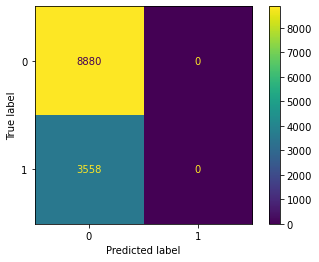

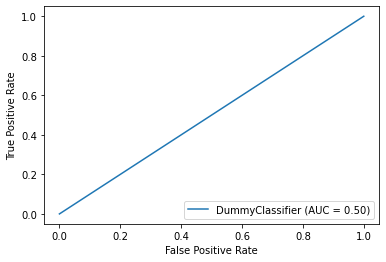

In [23]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(x_train_scaled, y_train)
y_hat_train = dummy_model.predict(x_train_scaled)
y_hat_test = dummy_model.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(dummy_model, x_test_scaled, y_test)
plot_roc_curve(dummy_model, x_test_scaled, y_test);

Decision Tree

Train 0.7462725804634394
Test 0.6630129286115796


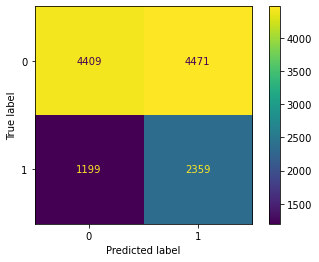

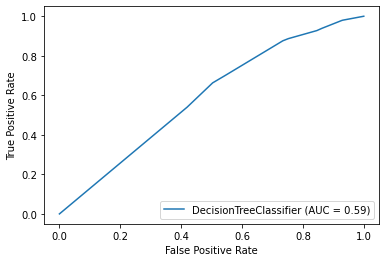

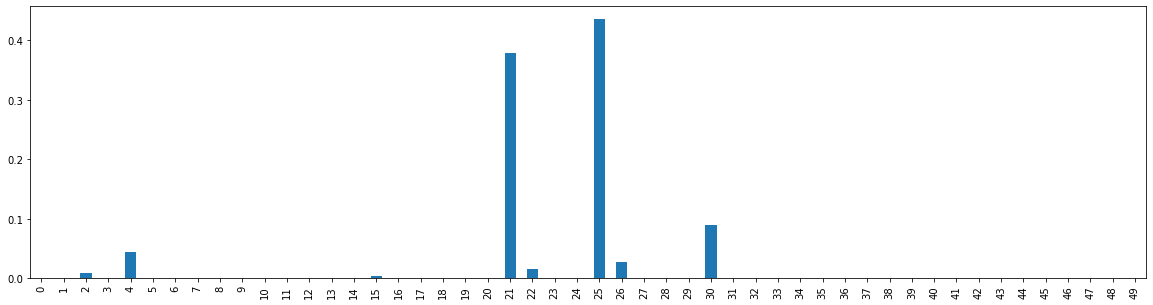

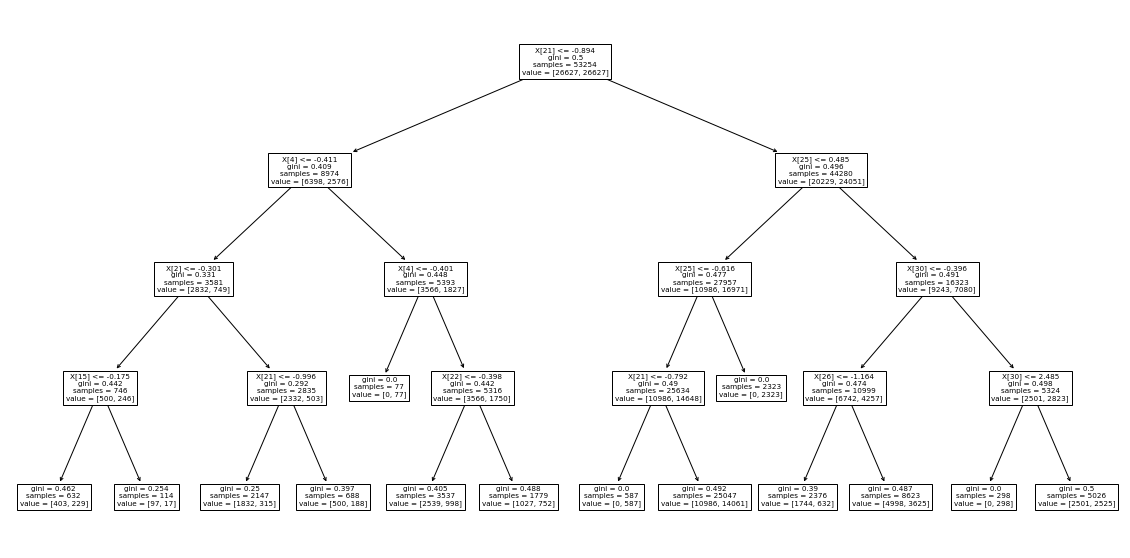

In [31]:
clf = DecisionTreeClassifier(max_depth = 4) 
clf.fit(x_train_scaled, y_train)
y_hat_train = clf.predict(x_train_scaled)
y_hat_test = clf.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(clf, x_test_scaled, y_test);
plot_roc_curve(clf, x_test_scaled, y_test);

ranking = clf.feature_importances_
fig, ax = plt.subplots(figsize=(20,5))
pd.Series(ranking).plot.bar(ax=ax);

f, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf);

LogReg

Train 0.6180568595786232
Test 0.5851602023608768
[[1.057912   0.81400469 0.93682116 0.97178161 1.11297729 1.0476469
  0.85117974 1.15792444 1.03589226 1.01406496 1.0247748  0.9224431
  0.95433895 1.0487823  1.06229327 0.94283063 0.95199893 0.99437271
  1.03402211 0.99075662 1.01709406 0.78528633 1.22957611 0.87127229
  1.12507217 0.99079642 1.44880474 0.85376343 1.00015435 1.05313594
  1.08239178 0.97614427 0.98102114 0.99723721 1.13457846 0.83921716
  1.00453355 0.99080361 1.0032667  1.09431502 1.0419895  0.99548307
  0.95500024 0.97534079 0.95303181 1.03665423 0.93490707 1.0928284
  0.88371749 1.01429065]]


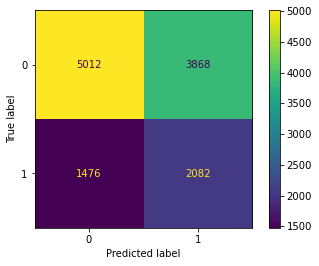

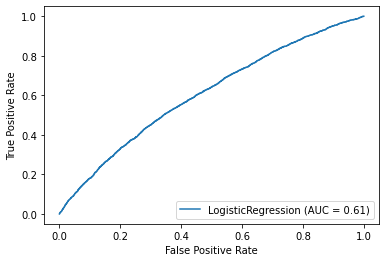

In [29]:
lr = LogisticRegression()
lr.fit(x_train_scaled, y_train)
y_hat_train = lr.predict(x_train_scaled) 
y_hat_test = lr.predict(x_test_scaled) 
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
print(np.exp(lr.coef_))
plot_confusion_matrix(lr, x_test_scaled, y_test)
plot_roc_curve(lr, x_test_scaled, y_test);

Basic KNN

Train 0.9330003380027792
Test 0.5188308038223721


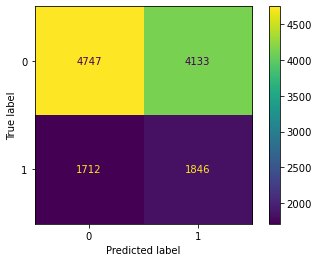

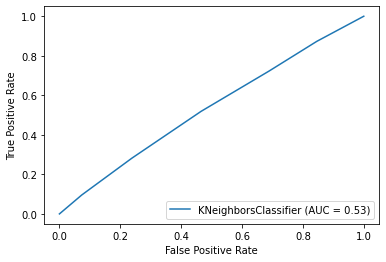

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15) 
mscale = MinMaxScaler()
x_train_mscaled = mscale.fit_transform(x_train) 
x_test_mscaled = mscale.transform(x_test)

sm = SMOTE(random_state=15)
x_train_mscaled, y_mtrain = sm.fit_resample(x_train_mscaled, y_train)

knn = KNeighborsClassifier() 
knn.fit(x_train_mscaled, y_mtrain)
y_hat_train = knn.predict(x_train_mscaled) 
y_hat_test = knn.predict(x_test_mscaled) 
print(f'Train {recall_score(y_mtrain, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(knn, x_test_mscaled, y_test); 
plot_roc_curve(knn, x_test_mscaled, y_test);

KNN GridSearchCV

In [41]:
grid = {'n_neighbors': [1, 3, 5],
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']}
gs = GridSearchCV(estimator=knn, param_grid=grid,scoring='recall', cv=5)
gs.fit(x_train_mscaled, y_mtrain)
print(gs.best_params_)
print(gs.best_score_)

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
0.9444515645632462


GridSearchCV Optimized KNN

Train 1.0
Test 0.3518830803822372


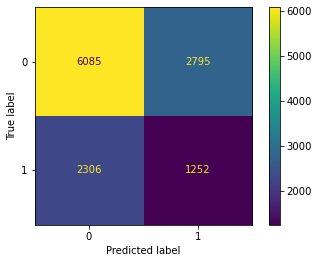

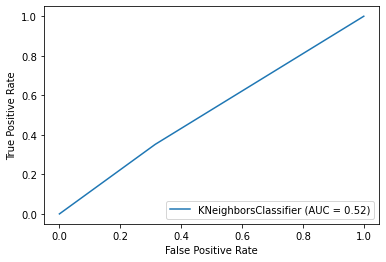

In [40]:
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors=1, weights = 'uniform' ) 
knn.fit(x_train_mscaled, y_mtrain)
y_hat_train = knn.predict(x_train_mscaled) 
y_hat_test = knn.predict(x_test_mscaled) 
print(f'Train {recall_score(y_mtrain, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(knn, x_test_mscaled, y_test); 
plot_roc_curve(knn, x_test_mscaled, y_test);

## Unused Models

Random Forest

Train 0.9399857287715476
Test 0.25323215289488477


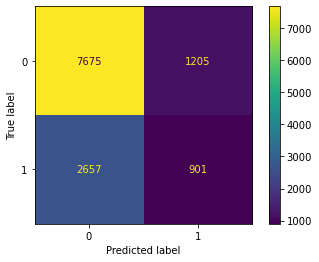

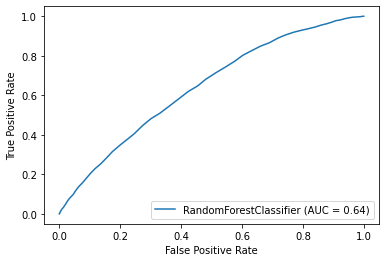

In [22]:
rfc = RandomForestClassifier(max_features='sqrt', max_samples=0.3) 
rfc.fit(x_train_scaled, y_train)
scores = cross_val_score(estimator=rfc, X=x_train_scaled, y=y_train, cv=5) 
y_hat_train = rfc.predict(x_train_scaled)
y_hat_test = rfc.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(rfc, x_test_scaled, y_test);
plot_roc_curve(rfc, x_test_scaled, y_test);

Adaboost

Train 0.6906523453637285
Test 0.37380550871275997


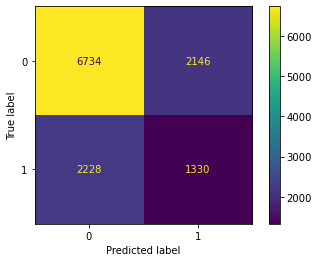

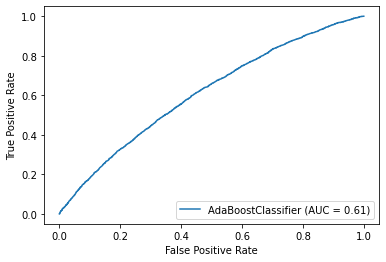

In [23]:
adb = AdaBoostClassifier()
adb.fit(x_train_scaled, y_train)
scores = cross_val_score(estimator=adb, X=x_train_scaled, y=y_train, cv=5) 
y_hat_train = adb.predict(x_train_scaled)
y_hat_test = adb.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(adb, x_test_scaled, y_test);
plot_roc_curve(adb, x_test_scaled, y_test);

GradientBoost

Train 0.6650016900138956
Test 0.1711635750421585


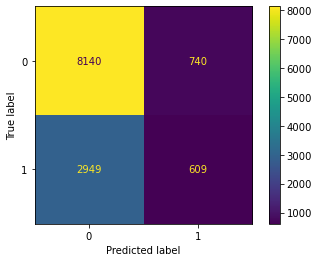

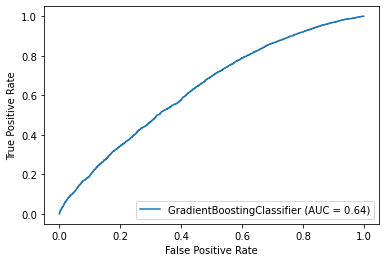

In [24]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train_scaled, y_train)
y_hat_train = gbc.predict(x_train_scaled)
y_hat_test = gbc.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(gbc, x_test_scaled, y_test);
plot_roc_curve(gbc, x_test_scaled, y_test);

XGBoost

Train 0.7666654148045218
Test 0.3679033164699269


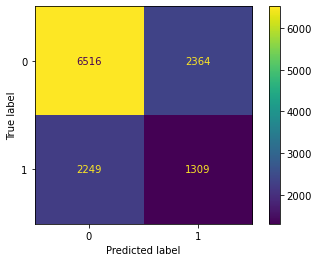

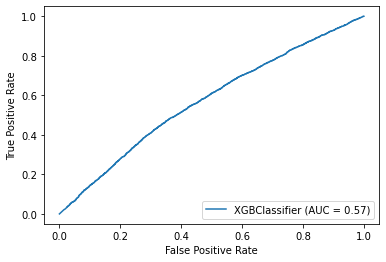

In [25]:
xgbc = XGBClassifier(eta=1, subsample=0.25)
xgbc.fit(x_train_scaled, y_train)
y_hat_train = xgbc.predict(x_train_scaled)
y_hat_test = xgbc.predict(x_test_scaled)
print(f'Train {recall_score(y_train, y_hat_train)}')
print(f'Test {recall_score(y_test, y_hat_test)}')
plot_confusion_matrix(xgbc, x_test_scaled, y_test);
plot_roc_curve(xgbc, x_test_scaled, y_test);